In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import os
import sys

In [2]:
# 将当前目录添加到path
sys.path.append('/home/huqian/data/py_code/cv/train')
sys.path

['/home/huqian',
 '/home/huqian/anaconda3/lib/python38.zip',
 '/home/huqian/anaconda3/lib/python3.8',
 '/home/huqian/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/home/huqian/anaconda3/lib/python3.8/site-packages',
 '/home/huqian/anaconda3/lib/python3.8/site-packages/IPython/extensions',
 '/home/huqian/.ipython',
 '/home/huqian/data/py_code/cv/train']

In [3]:
# from test.LossTrace import LossTrace
from utils.LossTrace import LossTrace
train_trace = LossTrace()
test_trace = LossTrace()

### 1. Load Data

In [4]:
root ='data/datasets'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root,train=True,transform=transform,download=True)
trainloader = torch.utils.data.DataLoader(
                                            trainset,
                                            batch_size=512,
                                            shuffle=True,
                                            num_workers=2
                                        )

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root,train=False,transform=transform,download=True)
testloader = torch.utils.data.DataLoader(
                                            testset,
                                            batch_size=512,
                                            shuffle=True,
                                            num_workers=2
                                        )

Files already downloaded and verified
Files already downloaded and verified


In [5]:
### 2. model optimizer ad lossfn

In [6]:
# prepare model
model = torchvision.models.resnet152(pretrained=True, progress=True)
model.to(device)

# prepare optimizer and loss
optimizer = torch.optim.SGD(model.parameters(),lr=0.02,momentum=0.02)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/huqian/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


### 3. Common Part

In [7]:
def count_loss(loader):
    # loader cannot be None
    if loader is None:
        warnings.warn('loader cannot be None!')
        return -13

    full = 0
    err = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs)
        prob, index = torch.max(F.softmax(output), dim=1)
        dif = index - labels

        full += index.size()[0]
        err += dif[dif != 0].size()[0]

    rate = round(err / full * 100, 4)
    return rate

### 4. Train Step

In [8]:
# param
model_name = 'resnet.pkl'
epoch_base = 0
epoch_steps = 10

In [24]:
# check if it exist, if True then load it
flag = os.path.exists(model_name)
if flag:
    sd = torch.load(model_name)
    model.load_state_dict(sd)

# Train
for epoch in range(epoch_steps):
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        if i % 20 == 19:
            print('epoch %3d, round %3d loss: %.7f' %
                (epoch + epoch_base + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            
        
            
            
# Save Model
torch.save(model.state_dict(),model_name)

# store train loss and test loss
epoch_idx = epoch + epoch_base + 1
train_loss = count_loss(trainloader)
test_loss = count_loss(testloader)
train_trace.append(epoch_idx,train_loss)
test_trace.append(epoch_idx,test_loss)

# modify params
epoch_base += epoch_steps

epoch  81, round  20 loss: 0.0001003
epoch  81, round  40 loss: 0.0001055
epoch  81, round  60 loss: 0.0001089
epoch  81, round  80 loss: 0.0001782
epoch  82, round  20 loss: 0.0001147
epoch  82, round  40 loss: 0.0000746
epoch  82, round  60 loss: 0.0000903
epoch  82, round  80 loss: 0.0001052
epoch  83, round  20 loss: 0.0001019
epoch  83, round  40 loss: 0.0000955
epoch  83, round  60 loss: 0.0000759
epoch  83, round  80 loss: 0.0001179
epoch  84, round  20 loss: 0.0000919
epoch  84, round  40 loss: 0.0000609
epoch  84, round  60 loss: 0.0000890
epoch  84, round  80 loss: 0.0000739
epoch  85, round  20 loss: 0.0000934
epoch  85, round  40 loss: 0.0002929
epoch  85, round  60 loss: 0.0001421
epoch  85, round  80 loss: 0.0000975
epoch  86, round  20 loss: 0.0000846
epoch  86, round  40 loss: 0.0002141
epoch  86, round  60 loss: 0.0001586
epoch  86, round  80 loss: 0.0001959
epoch  87, round  20 loss: 0.0000801
epoch  87, round  40 loss: 0.0012373
epoch  87, round  60 loss: 0.0001278
e

<ipython-input-7-a0cbc99013aa>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob, index = torch.max(F.softmax(output), dim=1)


### 5. Plot Step

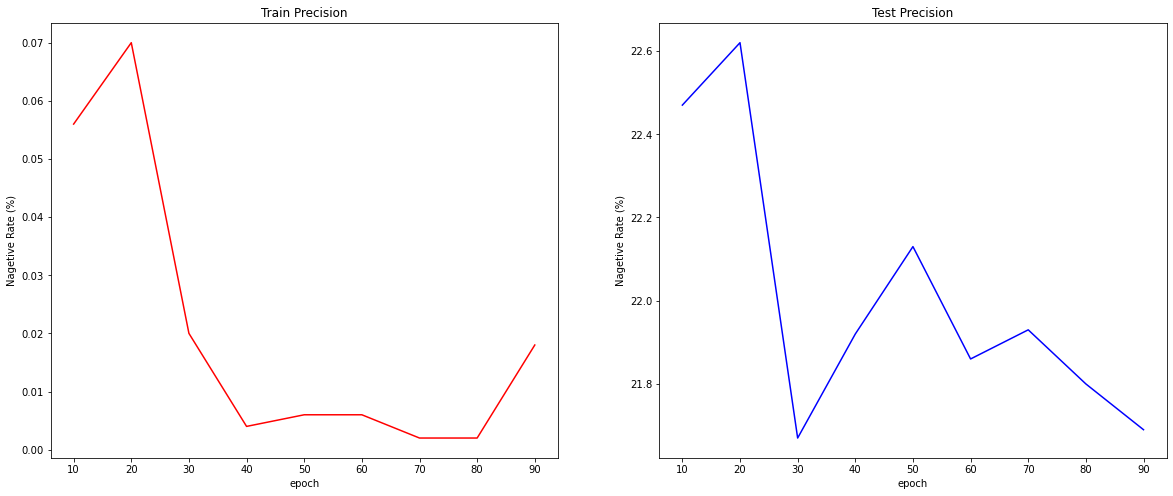

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Train Precision')
plt.xlabel('epoch')
plt.ylabel('Nagetive Rate (%)')
train_epoch, train_loss = train_trace.fetch()
plt.plot(train_epoch, train_loss,'r-')
plt.subplot(1,2,2)
plt.title('Test Precision')
plt.xlabel('epoch')
plt.ylabel('Nagetive Rate (%)')
test_epoch, test_loss = test_trace.fetch()
plt.plot(test_epoch, test_loss,'b-')

In [26]:
print("Test loss is : ",count_loss(testloader),"%")

<ipython-input-7-a0cbc99013aa>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob, index = torch.max(F.softmax(output), dim=1)


Test loss is :  21.52 %
